## Setup

In [1]:
import ugradio
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import lstsq
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift
from scipy.stats import norm, linregress
from scipy.optimize import curve_fit, least_squares
from scipy.signal import find_peaks, stft
from scipy.special import j1
from uncertainties import ufloat
import os
import glob
import time
from astropy.time import Time
from astropy.coordinates import EarthLocation
import astropy.units as u

No module named 'rtlsdr'


In [2]:
# Consistent Plot Params
titleSize = 15
axisSize = 15
legendSize = 13
graphSizeSingle = (8, 6)
graphSizeDouble = (15, 6)
graphSizeHorizontal = (20, 6)

## Data Extraction

In [3]:
def extractRawData(folder, filename):
    prefix = "ugastro\\Lab3Data\\" + folder
    raw_data = np.load(prefix + filename, allow_pickle=True)
    return raw_data

def getDataBlocks(data, buffer=10, num_blocks=2030):
    new_data = np.zeros((num_blocks, 1024), dtype=complex)
    for i, block in enumerate(data[buffer:num_blocks+buffer]):
        new_data[i] = normalize(block['corr01'])
    return new_data

def getRealImagData(data, buffer=10, num_blocks=2030):
    real_data = np.zeros((num_blocks, 1024), dtype=float)
    imag_data = np.zeros((num_blocks, 1024), dtype=complex)
    for i, block in enumerate(data[buffer:num_blocks+buffer]):
        #real_data[i] = normalize(block['corr01'].real)
        #imag_data[i] = normalize(block['corr01'].imag)
        real_data[i] = block['corr01'].real
        imag_data[i] = block['corr01'].imag
    return real_data, imag_data

def getComplexData(data, buffer=10, num_blocks=2030):
    complex_data = np.zeros((num_blocks, 1024), dtype=complex)
    for i, block in enumerate(data[buffer:num_blocks+buffer]):
        complex_data[i] = normalize(block['corr01'].real + (1j * block['corr01'].imag))
    return complex_data

def getDataSingleBlock(data, block=1):
    real = data['time_data'][block][:, 0]
    imag = data['time_data'][block][:, 1]
    return normalize(real + (1j * imag))

def getHorizonRawData(folder, extension="npy"):
    # Load and merge many files
    directory = "ugastro\\Lab3Data\\" + folder
    file_paths = sorted(glob.glob(os.path.join(directory, f"*.{extension}")))
    if not file_paths:
        print("No files found. Check the directory path and file extension.")
        return None
    
    data = []
    for file in file_paths:
        try:
            data.append(np.load(file, allow_pickle=True))
        except Exception as e:
            print(f"Error loading {file}: {e}")

    if data:
        merged_data = np.concatenate(data, axis=0)
        return merged_data
    else:
        print("No valid data files loaded.")
        return None

def normalize(data):
    return (data - np.mean(data)) #/ np.std(data)

def getUnixTimes(data, buffer=0):
    # Takes raw data
    times = [(data[i+buffer]['time']) for i in range(len(data)-buffer)]

    return times

def getTimesJD(data, buffer=0):
    # Takes raw data
    times = [(data[i+buffer]['time']/86400)+2440587.5 for i in range(len(data)-buffer)]

    return times

def getTimesLocal(data):
    # Takes raw data
    times = [time.gmtime(data[i]['time']) for i in range(len(data))]
    return times

def timestepToSec(timestep):
    # Takes a time step in seconds and converts to a datetime object
    return 1.25 * timestep


In [4]:
# Week 1
folder = "Week1_Testing\\"
data_test_raw = extractRawData(folder, "test_observatin_data.npy")
data_test = getDataBlocks(data_test_raw)
data_test_2_raw = extractRawData(folder, "Mar12_test_observation_data.npz")
data_test_2 = getDataBlocks(data_test_2_raw['arr_0'])

data_horizon_raw_1 = extractRawData(folder, "Mar13_12hour_observation_data.npz")
data_horizon_1 = getDataBlocks(data_horizon_raw_1['arr_0'], )

data_horizon_raw_2 = getHorizonRawData("Mar15_Observation")
data_horizon_2 = normalize(getDataBlocks(data_horizon_raw_2, buffer=0, num_blocks=28720))
print(len(data_horizon_2))

28720


In [5]:
horizon_real, horizon_imag = getRealImagData(data_horizon_raw_2, buffer=0, num_blocks=28720)
print(len(horizon_real))
print(len(horizon_imag))

horizon_complex = getComplexData(data_horizon_raw_2, buffer=0, num_blocks=28720)
print(horizon_complex.shape)
print(horizon_complex[0])

28720
28720
(28720, 1024)
[6.18995466+0.02812842j 0.40605558+0.02812842j 0.40605558+0.02812842j ...
 0.40605558+0.02812842j 0.40605558+0.02812842j 0.40605558+0.02812842j]


In [6]:
time_data = getUnixTimes(data_horizon_raw_2, buffer=0)
time_data_jd = getTimesJD(data_horizon_raw_2, buffer=0)
LOC = EarthLocation(lat=37.873199*u.deg, lon=-122.257063*u.deg, height=120*u.m)
times = Time(time_data, format='unix', location=LOC)
LSTs = times.sidereal_time('apparent', longitude=LOC.lon).radian % (2 * np.pi)

RAs, DECs, HAs = np.zeros(len(time_data)), np.zeros(len(time_data)), np.zeros(len(time_data))
for i in range(len(time_data)):
    ra, dec = ugradio.coord.sunpos(time_data_jd[i])
    RAs[i] = np.radians(ra)
    HAs[i] = LSTs[i] - np.radians(ra)
    DECs[i] = np.radians(dec)
    
w_earth = (2 * np.pi) / (24 * 60 * 60)
wavelen = 0.025
L = np.radians(37.873199)
b_ew_guess = 20
b_ns_guess = 0

print(len(HAs))

28720


In [7]:
print(len(time_data))
step = 2000
for i in range(0, len(HAs), step):
    print(f"jd = {time_data_jd[i]}, RA = {RAs[i]}, LST = {LSTs[i]}, HAs = {HAs[i]}")

28720
jd = 2460750.1474417555, RA = 6.202195307541056, LST = 4.96218682183104, HAs = -1.2400084857100167
jd = 2460750.1763795596, RA = 6.2026573498283755, LST = 5.144506198724753, HAs = -1.0581511511036226
jd = 2460750.2053176025, RA = 6.203119382418845, LST = 5.326827079928264, HAs = -0.8762923024905813
jd = 2460750.2342548883, RA = 6.20358138945035, LST = 5.509143192679575, HAs = -0.6944381967707747
jd = 2460750.2631916376, RA = 6.204043374488607, LST = 5.691455924520362, HAs = -0.5125874499682448
jd = 2460750.2921294933, RA = 6.204505363802754, LST = 5.873775626062808, HAs = -0.3307297377399463
jd = 2460750.321067571, RA = 6.2049673433150305, LST = 6.056096729467852, HAs = -0.14887061384717892
jd = 2460750.3500040104, RA = 6.205429283360815, LST = 6.2384075080091845, HAs = 0.03297822464836919
jd = 2460750.3789423867, RA = 6.205891241064851, LST = 0.1375451829035466, HAs = -6.068346058161304
jd = 2460750.4078796506, RA = 6.206353167784735, LST = 0.31986115617218586, HAs = -5.88649201

c:\Users\brand\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\brand\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


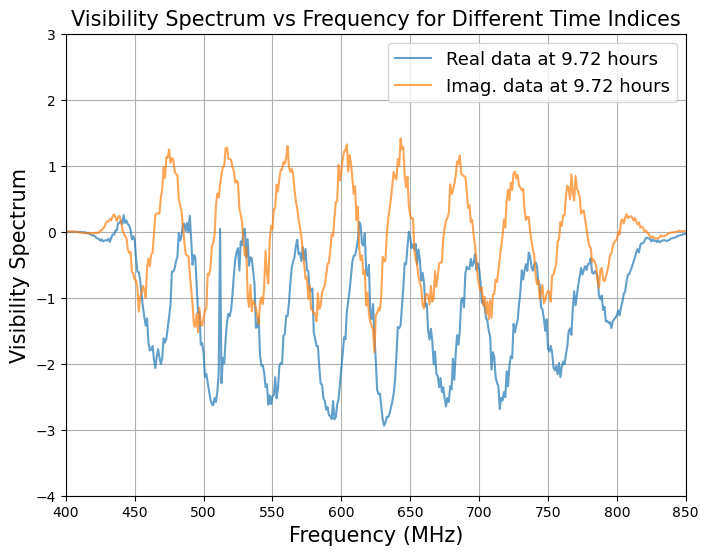

In [8]:
def plot_power_spectrum(data, indices=[100], xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)

    for index in indices:
        spectrum = data[index]
        plt.plot(spectrum, label=f"time index = {index}", alpha=0.7)
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Visibility Spectrum", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Visibility Spectrum vs Frequency for Different Time Indices", size=titleSize)
    plt.grid()
    plt.show()

def plot_power_spectrum_complex(data_real, data_imag, indices=[100], xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    times = [(x*1.25)/3600 for x in range(len(data_real))]

    for index in indices:
        spectrum_real = data_real[index]
        spectrum_imag = data_imag[index]
        plt.plot(spectrum_real, label=f"Real data at {round(times[index], 2)} hours", alpha=0.7)
        plt.plot(spectrum_imag, label=f"Imag. data at {round(times[index], 2)} hours", alpha=0.7)

    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Visibility Spectrum", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Visibility Spectrum vs Frequency for Different Time Indices", size=titleSize)
    plt.grid()
    plt.show()

#plot_power_spectrum(data_horizon_2, indices=[23000, 28000], xlim=(400, 850), ylim=(-4, 3))
#plot_power_spectrum_complex(horizon_real, horizon_imag, indices=[10000], xlim=(400, 850), ylim=(-4, 3))
#plot_power_spectrum_complex(horizon_real, horizon_imag, indices=[23000], xlim=(400, 850), ylim=(-4, 3))
plot_power_spectrum_complex(horizon_real, horizon_imag, indices=[28000], xlim=(400, 850), ylim=(-4, 3))

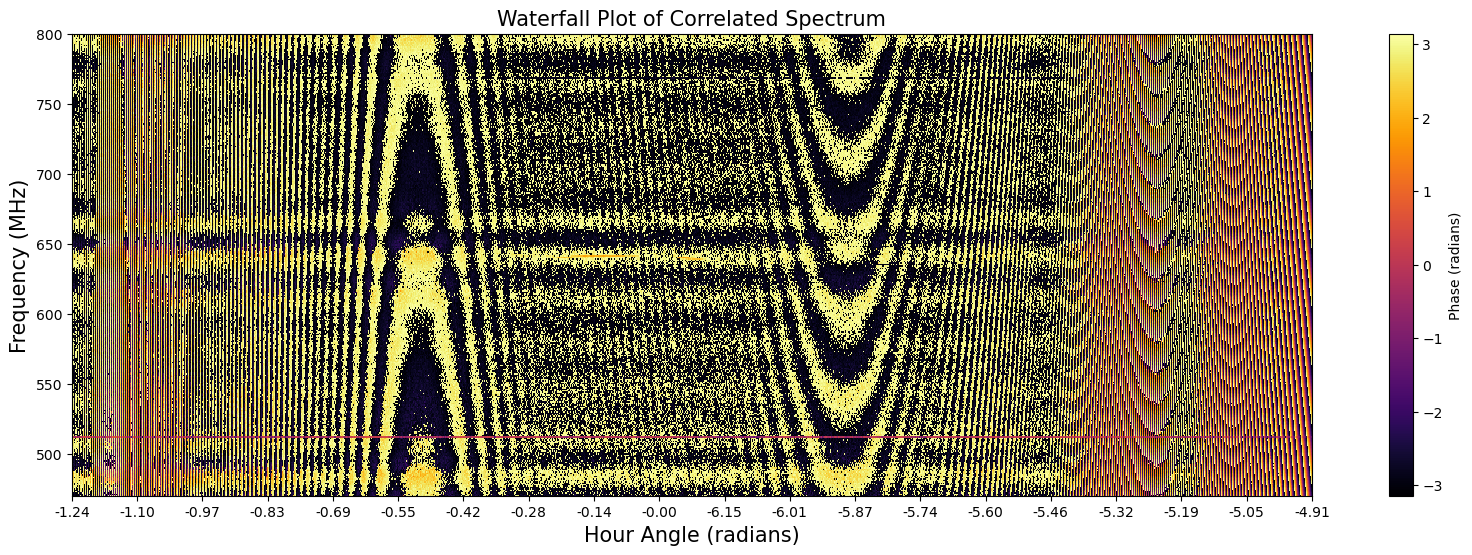

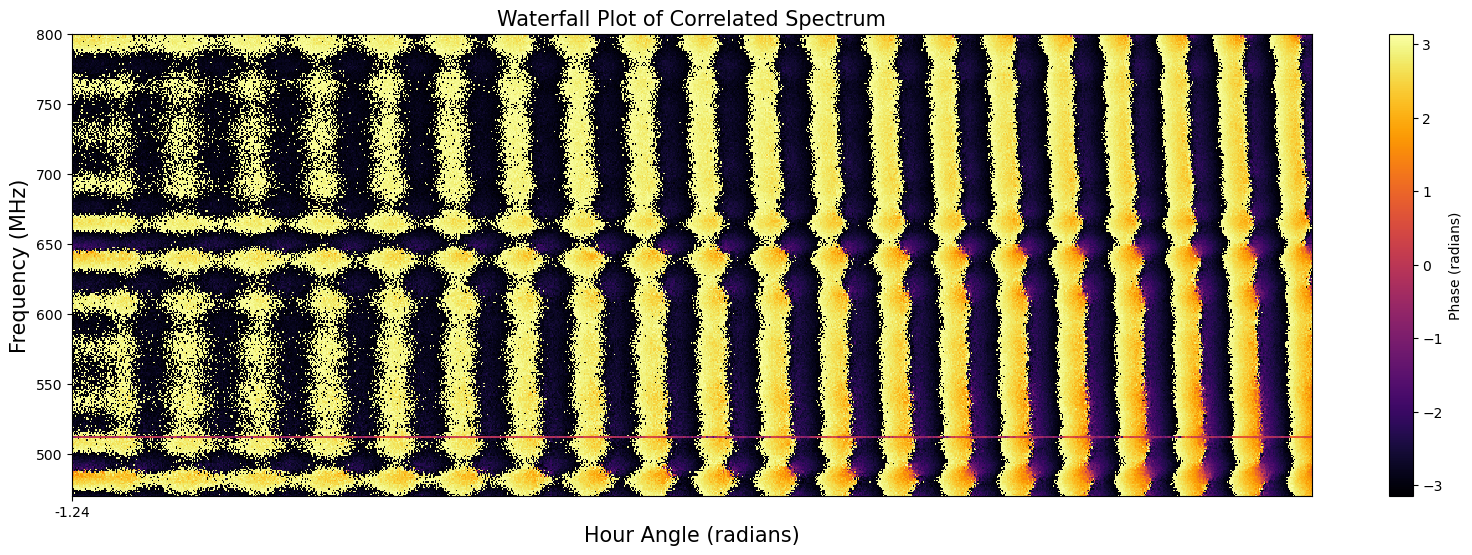

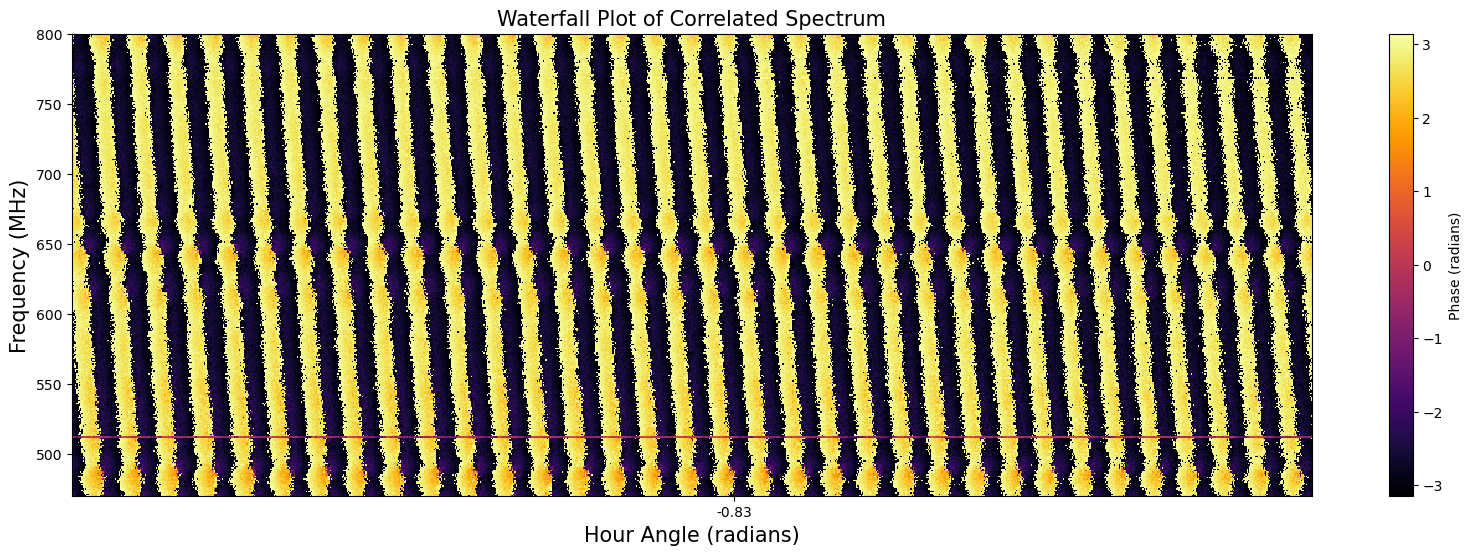

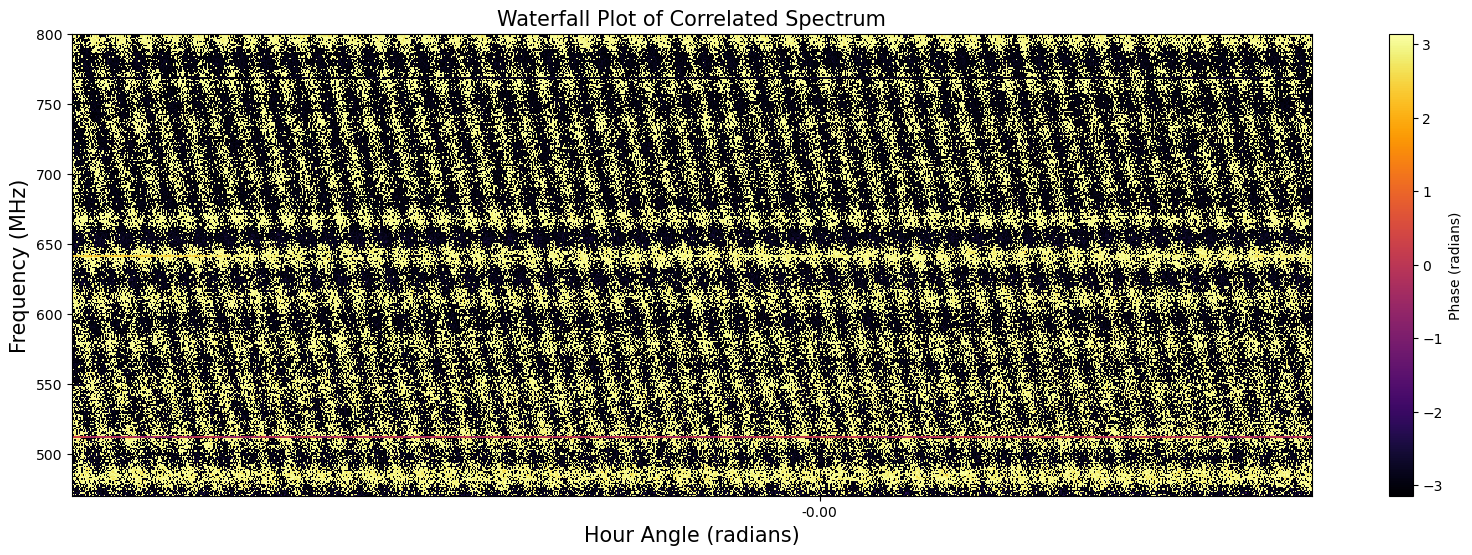

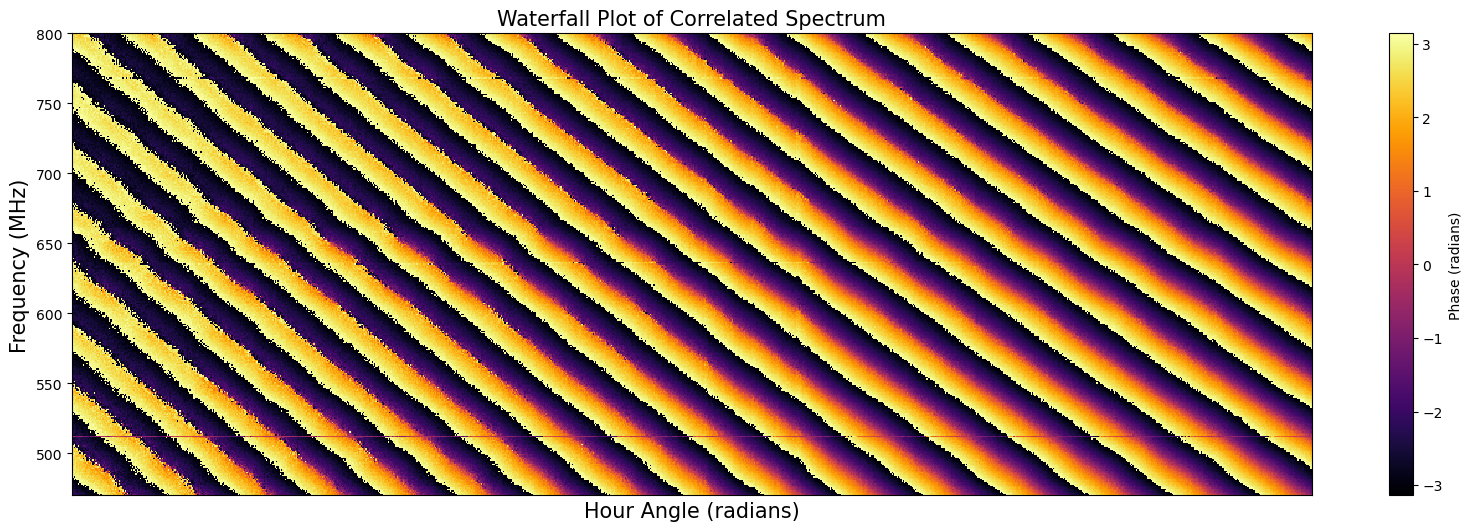

In [9]:
def plot_waterfall(data, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    plt.imshow(np.abs(data), aspect='auto', cmap='inferno', norm='linear',
                interpolation='nearest', origin='lower')
    plt.colorbar(label="Power (Arbitrary Scale)")
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Time Step", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Waterfall Plot of Correlated Spectrum", size=titleSize)
    plt.show()

def plot_waterfall_corr(data, baseline, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    plt.imshow(np.abs(data) - np.abs(baseline), aspect='auto', cmap='inferno', norm='linear',
               interpolation='nearest', origin='lower')
    plt.colorbar(label="Power (Arbitrary Scale)")
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Time Step", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Waterfall Plot of Correlated Spectrum", size=titleSize)
    plt.show()

def plot_waterfall_any(data_real, data_imag, mode='real', xlim=None, ylim=None):
    plt.figure(figsize=graphSizeHorizontal)

    if mode == 'real':
        display_data = (data_real.T).astype(float)
        label = "Real Component"
    elif mode == 'imag':
        display_data = (data_imag.T).astype(float)
        label = "Imaginary Component"
    elif mode == 'phase (real)':
        display_data = (np.angle(data_real.T)).astype(float)
        label = "Real Phase (radians)"
    elif mode == 'phase (imag)':
        display_data = (np.angle(data_imag.T)).astype(float)
        label = "Imaginary Phase (radians)"
    else:
        raise ValueError(f"Unknown mode '{mode}'. Choose from 'real', 'imag', 'phase (real)', or phase (imag).")
    
    plt.imshow(display_data, aspect='auto', cmap='inferno', norm='linear', interpolation='nearest', origin='lower')
    plt.colorbar(label=label)
    plt.xlabel("Time Step", fontsize=axisSize)
    plt.ylabel("Frequency (MHz)", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(f"Waterfall Plot of {label} of Correlated Spectrum", size=titleSize)
    plt.show()

def plot_waterfall_complex(data_complex, xunits='radians', nticks=20, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeHorizontal)
    display_data = (np.angle(data_complex.T))
    plt.imshow(display_data, aspect='auto', cmap='inferno', norm='linear', interpolation='nearest', origin='lower')
    plt.colorbar(label="Phase (radians)")

    nt = data_complex.shape[0]
    xticks = np.linspace(0, nt - 1, nticks, dtype=int)
    if xunits == 'degrees':
        xlabels = np.rad2deg(HAs[xticks]) + 360
        xlabel = "Hour Angle (degrees)"
    else:
        xlabels = HAs[xticks]
        xlabel = "Hour Angle (radians)"

    plt.xticks(xticks, [f"{val:.2f}" for val in xlabels])
    plt.xlabel(xlabel, fontsize=axisSize)
    plt.ylabel("Frequency (MHz)", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(f"Waterfall Plot of Correlated Spectrum", size=titleSize)
    plt.show()


#plot_waterfall(data_test)
#plot_waterfall(data_test_2)
#plot_waterfall_corr(data_test[:400], data_test_2[:400], xlim=(220, 400))
#plot_waterfall(data_horizon_2, xlim=(470, 800))
#plot_waterfall(data_horizon_2, xlim=(470, 800), ylim=(0, 1000))
#plot_waterfall(data_horizon_2, xlim=(470, 800), ylim=(4000, 5000))
#plot_waterfall(data_horizon_2, xlim=(470, 800), ylim=(12500, 13000))
#plot_waterfall(data_horizon_2, xlim=(470, 800), ylim=(22000, 23000))
#plot_waterfall(data_horizon_2, xlim=(470, 800), ylim=(25000, 28600))

#plot_waterfall(horizon_real)
#plot_waterfall_any(horizon_real, horizon_imag, mode='real', ylim=(470, 800))
#plot_waterfall_any(horizon_real, horizon_imag, mode='imag', ylim=(470, 800))
#plot_waterfall_any(horizon_real, horizon_imag, mode='phase (real)', ylim=(470, 800))
#plot_waterfall_any(horizon_real, horizon_imag, mode='phase (imag)', ylim=(470, 800))
#
#plot_waterfall_any(horizon_real, horizon_imag, mode='phase (imag)', ylim=(470, 800), xlim=(0, 1000))
#plot_waterfall_any(horizon_real, horizon_imag, mode='phase (imag)', ylim=(470, 800), xlim=(13000, 14000))

plot_waterfall_complex(horizon_complex, ylim=(470, 800))
plot_waterfall_complex(horizon_complex, ylim=(470, 800), xlim=(0, 1000))
plot_waterfall_complex(horizon_complex, ylim=(470, 800), xlim=(4000, 5000))
plot_waterfall_complex(horizon_complex, ylim=(470, 800), xlim=(13000, 14000))
plot_waterfall_complex(horizon_complex, ylim=(470, 800), xlim=(26000, 27000))

In [10]:
def plot_time_delay(data, indices=[100], xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    times = [2*i for i in range(len(data[0]))] # 2ms per sample

    for index in indices:
        time_signal = np.abs(ifft(data[index]))
        amplitude = np.abs(time_signal)
        threshold = 0.2 * np.max(amplitude)
        peaks, properties = find_peaks(amplitude, height=threshold)
        if index == 0:
            print(f"Peak = {peaks}")

        plt.plot(times, amplitude, label=f"Time Index = {index}", alpha=0.7)
        plt.scatter(peaks*2, amplitude[peaks], color='r', marker='o', alpha=0.7)
    plt.xlabel("Time Delay (ms)", fontsize=axisSize)
    plt.ylabel("Power Spectrum (Arbitrary Scale)", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Power Spectrum vs Time Delay", size=titleSize)
    plt.grid()
    plt.show()
    return peaks, properties

def plot_time_delay_corr(data, baseline, indices=[100], offset=0, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    times = [2*i for i in range(len(data[0]))] # 2ms per sample

    for index in indices:
        time_signal = np.abs(ifft(data[index]))
        time_signal_baseline = np.abs(ifft(baseline[index]))
        amplitude = np.abs(time_signal)
        amplitude_baseline = np.abs(time_signal_baseline)
        amplitude -= amplitude_baseline
        threshold = 0.2 * np.max(amplitude)
        peaks, properties = find_peaks(amplitude, height=threshold)

        plt.plot(times, amplitude, label=f"Time Index = {offset+index}", alpha=0.7)
        plt.scatter(peaks*2, amplitude[peaks], color='r', marker='o', alpha=0.7)
    plt.xlabel("Time Delay (ms)", fontsize=axisSize)
    plt.ylabel("Power Spectrum (Arbitrary Scale)", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Power Spectrum vs Time Delay", size=titleSize)
    plt.grid()
    plt.show()
    return peaks, properties

#plot_time_delay(data_test, indices=[100, 200, 300, 400, 500], xlim=(0, 200))
#plot_time_delay(data_test_2, indices=[100, 200, 300, 400, 500], xlim=(0, 200))
#peaks, amps = plot_time_delay_corr(data_test[:450], data_test_2[:450], indices=[100, 200, 300, 400], xlim=(0, 200))
#print(f"Peaks = {peaks[0]}")
#print(f"Amplitudes = {np.round(amps['peak_heights'][0], 3)}")

#plot_time_delay(data_horizon_2, indices=[100, 500, 1000, 10000, 15000, 20000])
#plot_time_delay_corr(data_horizon_2[28000:28450], data_test_2[:450], indices=[100, 200, 300, 400], offset=28000, xlim=(0, 200))

In [11]:
def plot_phase_evolution(data, freq_bin=512):
    time_steps = np.arange(data.shape[0])
    phases = np.angle(data[:, freq_bin])  # Extract column (frequency bin) and compute phase

    plt.figure(figsize=graphSizeSingle)
    plt.plot(time_steps, phases, marker='o', linestyle='-', label=f"Frequency Bin {freq_bin}")
    plt.xlabel("Time Step", fontsize=axisSize)
    plt.ylabel("Phase (radians)", fontsize=axisSize)
    plt.title(f"Fringe Phase Evolution at Frequency Bin {freq_bin}", size=titleSize)
    plt.legend(fontsize=legendSize)
    plt.grid()
    plt.show()

def plot_phase_waterfall(data, xlim=None, ylim=None):
    phases = np.angle(data)

    plt.figure(figsize=graphSizeSingle)
    plt.imshow(phases, aspect='auto', cmap='twilight', norm='linear',
               extent=[0, 500, 0, data.shape[0]], interpolation='nearest',
               origin='lower')
    plt.colorbar(label="Phase (radians)")
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Time Step", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Waterfall Plot of Correlated Spectrum Phase", size=titleSize)
    plt.show()

def plot_phase_waterfall_complex(data_real, data_imag, real=True, xlim=None, ylim=None):
    phases = np.angle(data_real) if real else np.angle(data_imag)

    plt.figure(figsize=graphSizeSingle)
    #plt.imshow(phases, aspect='auto', cmap='twilight', norm='linear',
    #           extent=[0, 1024, 0, data_real.shape[0]], interpolation='nearest',
    #           origin='lower')
    plt.imshow(phases, aspect='auto', cmap='twilight', norm='linear', origin='lower')
    plt.colorbar(label="Phase (radians)")
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Time Step", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Waterfall Plot of Correlated Spectrum Phase", size=titleSize)
    plt.show()

#plot_phase_waterfall_complex(horizon_real, horizon_imag)
#plot_phase_waterfall_complex(horizon_real, horizon_imag, real=False)

#plot_phase_evolution(data_test[:450])
#plot_phase_evolution(data_horizon_2[28200:])
#plot_phase_waterfall(data_test[:450], xlim=(220, 400))
#plot_phase_waterfall(data_horizon_2[2000:5000], xlim=(220, 400))
#plot_phase_waterfall(data_horizon_2[28000:], xlim=(220, 400))

c:\Users\brand\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\brand\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


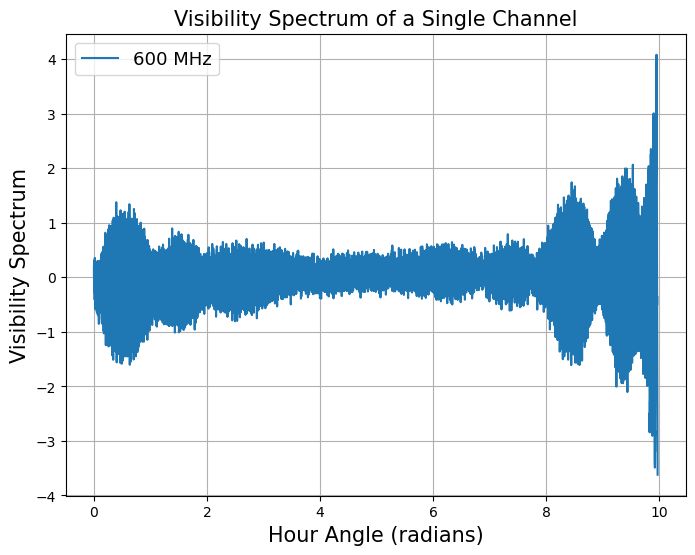

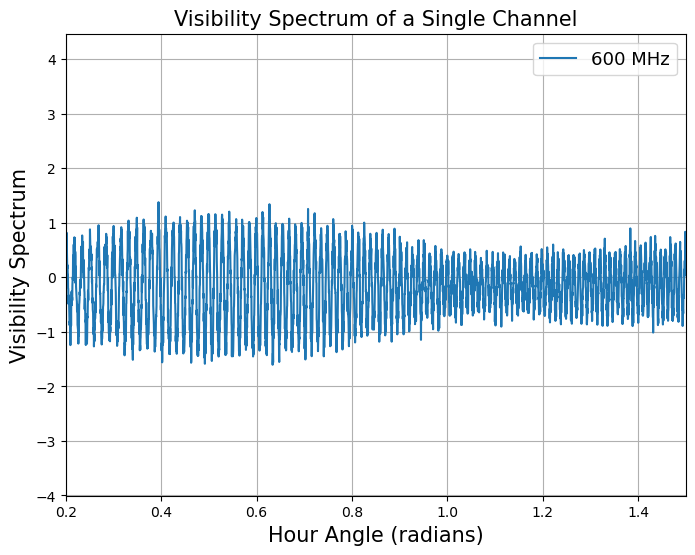

In [12]:
def graphSingleChannelOverTime(data, channel=600, xlim=None, ylim=None):
    # 450 < channel < 800
    plt.figure(figsize=graphSizeSingle)
    channel_data = normalize(data[:, channel])
    times = [(x*1.25)/3600 for x in range(len(data))]

    plt.plot(times, channel_data, label=f"{channel} MHz")
    plt.xlabel("Hour Angle (radians)", fontsize=axisSize)
    plt.ylabel("Visibility Spectrum", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Visibility Spectrum of a Single Channel", size=titleSize)
    plt.grid()
    plt.show()

graphSingleChannelOverTime(horizon_complex, channel=600)
graphSingleChannelOverTime(horizon_complex, channel=600, xlim=(0.2, 1.5))

In [13]:
def graphOverlayPowerSpectra(data, sample_rate, channel=600, indices=[5000, 10000, 20000, 25000], window=100, xlim=None):
    plt.figure(figsize=graphSizeSingle)
    channel_data = normalize(data[:, channel])

    for index in indices:
        spectrum = np.abs(fftshift(fft(channel_data[index-window:index+window]))) ** 2
        freqs = fftshift(fftfreq(len(spectrum), sample_rate))
        plt.plot(freqs, spectrum, label=f"Time Index = {index}", alpha=0.7)
   
    plt.xlim(xlim)
    plt.xlabel("Frequency (Hz)", fontsize=axisSize)
    plt.ylabel("Power (Arbitary Scale)", fontsize=axisSize)
    plt.title(f"Power Spectra at Different Times", size=titleSize)
    plt.legend()
    plt.grid(True)
    plt.show()

def graphFringeFreqOverTime(data, sample_rate=1.25, channel=600, resampling=True, window=300, vertical_line=None, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    #channel_data = normalize(data[:, channel])
    channel_data = data[:, channel]
    #indices = np.linspace(101, len(channel_data) - 101, len(channel_data) - 202, dtype=int)
    #indices = np.linspace(301, len(channel_data) - 301, len(channel_data) - 602, dtype=int)
    #max_freqs = np.zeros(len(channel_data) - 202)
    #max_freqs = np.zeros(len(channel_data) - 602)

    indices = np.linspace(window+1, len(channel_data)-(window+1), len(channel_data)-2*(window+1), dtype=int)
    max_freqs = np.zeros(len(channel_data)-2*(window+1))


    for i, index in enumerate(indices):
        spectrum = np.abs(fft(channel_data[index-window:index+window])) ** 2        
        freqs = fftfreq(len(spectrum), d=1/sample_rate)

        bad_mask = (freqs >= -0.00) & (freqs <= 0.003)
        good_mask = ~bad_mask
        #max_freqs[i] = np.abs(freqs[np.argmax(spectrum[good_mask])])
        max_freq = np.abs(freqs[np.argmax(spectrum[good_mask])])
        if max_freq < 0.01 or max_freq > 0.07:
            max_freqs[i] = max_freqs[i-1]
        else:
            max_freqs[i] = max_freq

    # Accounting for weird vertical lines in data when it should be smooth
    if resampling:
        max_freqs[11100:11225] = max_freqs[11090]
        max_freqs[11225:11350] = max_freqs[11360]

    plt.scatter(indices, max_freqs, color='r', alpha=0.7)
   
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel("Timestep", fontsize=axisSize)
    plt.ylabel("Fringe Frequency", fontsize=axisSize)
    plt.title(f"Fringe Frequency Over Time", size=titleSize)
    plt.grid(True)
    if vertical_line is not None:
        plt.axvline(x=vertical_line, linestyle='--', color='blue', label=f'Noon (PST Standard Time)')
        plt.legend()
    plt.show()

    return max_freqs

def fringe_freq_stft(data, sample_rate=1.25, channel=600, nperseg=600, noverlap=550,
                     fmin=0.01, fmax=0.07, resampling=True, vertical_line=None, xlim=None, ylim=None):
    channel_data = normalize(data[:, channel])
    
    # Compute STFT
    f, t, Zxx = stft(channel_data, fs=sample_rate, nperseg=nperseg, noverlap=noverlap)
    power = np.abs(Zxx)**2

    # Select band-limited range of frequencies
    freq_mask = (f >= fmin) & (f <= fmax)
    f_band = f[freq_mask]
    power_band = power[freq_mask, :]

    # Find dominant frequency in band for each time step
    max_freqs = f_band[np.argmax(power_band, axis=0)]
    indices = (t * sample_rate).astype(int)  # convert time axis to sample indices

    # Optional smoothing to fix known spikes
    if resampling:
        # Use your original correction as an example
        idx_mask = (indices >= 11100) & (indices < 11225)
        max_freqs[idx_mask] = max_freqs[np.where(indices == 11090)[0][0]]
        idx_mask = (indices >= 11225) & (indices < 11350)
        max_freqs[idx_mask] = max_freqs[np.where(indices == 11360)[0][0]]

    # Plotting
    plt.figure(figsize=graphSizeSingle)
    plt.scatter(indices, max_freqs, color='orange', alpha=0.7)
    plt.xlabel("Timestep", fontsize=axisSize)
    plt.ylabel("Fringe Frequency (Hz)", fontsize=axisSize)
    plt.title("Fringe Frequency Over Time (STFT)", fontsize=titleSize)
    plt.grid(True)
    if xlim: plt.xlim(xlim)
    if ylim: plt.ylim(ylim)
    if vertical_line is not None:
        plt.axvline(x=vertical_line, linestyle='--', color='blue', label=f'Noon (PST)')
        plt.legend()
    plt.show()

#graphOverlayPowerSpectra(horizon_imag, sample_rate=1.25, indices=[1000, 2000, 3000, 4000, 5000], channel=600, xlim=(0, 0.06))
#graphOverlayPowerSpectra(horizon_imag, sample_rate=1.25, indices=[6000, 7000, 8000, 9000, 10000], channel=600, xlim=(0, 0.06))
#graphOverlayPowerSpectra(horizon_imag, sample_rate=1.25, indices=[11000, 12000, 13000, 14000, 15000], window=200, channel=600, xlim=(0, 0.06))
#graphOverlayPowerSpectra(horizon_imag, sample_rate=1.25, indices=[16000, 17000, 18000, 19000, 20000], channel=600, xlim=(0, 0.06))
#graphOverlayPowerSpectra(horizon_imag, sample_rate=1.25, indices=[21000, 22000, 23000, 24000, 25000], channel=600, xlim=(0, 0.06))
#graphOverlayPowerSpectra(horizon_imag, sample_rate=1.25, indices=[26000, 27000, 28000], channel=600, xlim=(0, 0.06))

#graphOverlayPowerSpectra(horizon_imag, sample_rate=1.25, indices=[14000, 19000], window=200, channel=600, xlim=(0.028, 0.04))

#graphFringeFreqOverTime(horizon_imag, sample_rate=1.25, channel=600, mask=False, vertical_line=10769, ylim=(0, 0.07))
#graphFringeFreqOverTime(horizon_imag, sample_rate=1.25, channel=600, mask=True, vertical_line=107969, ylim=(0, 0.07))

noon_timestep = 10769+2079 # PST, Daylight Savings accounting 
#graphOverlayPowerSpectra(horizon_complex, sample_rate=1.25, indices=[11001, 15000], window=100, channel=600, xlim=(-0.1, 0.1))
#graphOverlayPowerSpectra(horizon_complex, sample_rate=1.25, indices=[11001, 15000], window=250, channel=600, xlim=(-0.1, 0.1))
#graphOverlayPowerSpectra(horizon_complex, sample_rate=1.25, indices=[11001, 15000], window=300, channel=600, xlim=(-0.1, 0.1))

#graphFringeFreqOverTime(horizon_complex, sample_rate=1.25, channel=600, window=325, vertical_line=noon_timestep, ylim=(0.01, 0.07))
#graphFringeFreqOverTime(horizon_complex, sample_rate=1.25, channel=600, window=335, vertical_line=noon_timestep, ylim=(0.01, 0.07))
#graphFringeFreqOverTime(horizon_complex, sample_rate=1.25, channel=600, window=345, vertical_line=noon_timestep, ylim=(0.01, 0.07))
#graphFringeFreqOverTime(horizon_complex, sample_rate=1.25, channel=600, window=350, vertical_line=noon_timestep, ylim=(0.01, 0.07))
#graphFringeFreqOverTime(horizon_complex, sample_rate=1.25, channel=600, window=355, vertical_line=noon_timestep, ylim=(0.01, 0.07))
#graphFringeFreqOverTime(horizon_complex, sample_rate=1.25, channel=600, window=360, vertical_line=noon_timestep, ylim=(0.01, 0.07))
#graphFringeFreqOverTime(horizon_complex, sample_rate=1.25, channel=600, window=365, vertical_line=noon_timestep, ylim=(0.01, 0.07))
#graphFringeFreqOverTime(horizon_complex, sample_rate=1.25, channel=600, window=370, vertical_line=noon_timestep, ylim=(0.01, 0.07))
#graphFringeFreqOverTime(horizon_complex, sample_rate=1.25, channel=600, window=375, vertical_line=noon_timestep, ylim=(0.01, 0.07))

#fringe_freq_stft(horizon_complex, sample_rate=1.25, channel=600, nperseg=600, noverlap=550,
#                     fmin=0.01, fmax=0.07, resampling=True, vertical_line=noon_timestep, ylim=(0.01, 0.07))

In [14]:
time_data_jd = getTimesJD(data_horizon_raw_2)
time_data_utc = getTimesLocal(data_horizon_raw_2)
print("Started Mar 15, 8:32:19 AM PST")
print("Ended Mar 15, 6:30:41 PM PST")
print("Difference of 9hr, 58 mins, 22 sec (or 35902 total sec)")
print("28720 time steps")
print("1.25 seconds per time step")

Started Mar 15, 8:32:19 AM PST
Ended Mar 15, 6:30:41 PM PST
Difference of 9hr, 58 mins, 22 sec (or 35902 total sec)
28720 time steps
1.25 seconds per time step


In [15]:
time_data = getUnixTimes(data_horizon_raw_2, buffer=0)
time_data_jd = getTimesJD(data_horizon_raw_2, buffer=0)
LOC = EarthLocation(lat=37.873199*u.deg, lon=-122.257063*u.deg, height=120*u.m)
times = Time(time_data, format='unix', location=LOC)
LSTs = times.sidereal_time('apparent', longitude=LOC.lon).radian

RAs, DECs, HAs = np.zeros(len(time_data)), np.zeros(len(time_data)), np.zeros(len(time_data))
for i in range(len(time_data)):
    ra, dec = ugradio.coord.sunpos(time_data_jd[i])
    RAs[i] = np.radians(ra)
    HAs[i] = LSTs[i] - np.radians(ra)
    DECs[i] = np.radians(dec)

In [16]:
print(len(HAs))
print(len(RAs))
print(len(DECs))
print(len(time_data))

28720
28720
28720
28720


In [17]:
w_earth = (2 * np.pi) / (24 * 60 * 60)
#wavelen = 0.025
#wavelen = 0.0285516627
wavelen = 0.0299792458
L = np.radians(37.873199)
b_ew_guess = 20
b_ns_guess = 0

def constructDesignMatrix(indices, observed_fringe_freqs, HAs, DECs, L, w_earth, wavelen, good_mask=None, undersample=False, step=5):
    if good_mask is None:
        good_mask = np.ones_like(indices, dtype=bool)

    indices_clean = indices[good_mask]
    HAs_clean = HAs[indices_clean]
    DECs_clean = DECs[indices_clean]
    observed_fringe_clean = np.array(observed_fringe_freqs)[good_mask]

    if undersample:
        indices_clean = indices_clean[::step]
        HAs_clean = HAs_clean[::step]
        DECs_clean = DECs_clean[::step]
        observed_fringe_clean = observed_fringe_clean[::step]

    A = (1 / wavelen) * np.cos(DECs_clean) * np.cos(HAs_clean)
    B = -(1 / wavelen) * np.sin(L) * np.cos(DECs_clean) * np.sin(HAs_clean)
    X = np.vstack([A, B]).T
    y = np.array(observed_fringe_clean) / w_earth

    return X, y, indices_clean, HAs_clean, DECs_clean, observed_fringe_clean

In [18]:
def fit_baseline_least_squares(X, y, initial_guess=(20.0, 0.0)):    
    def residuals(beta, X, y):
        b_ew, b_ns = beta
        return X @ np.array([b_ew, b_ns]) - y

    #lower_bounds = (18.5, -1.5)
    #upper_boudns = (21.5, 1.5)
    result = least_squares(residuals, initial_guess, args=(X, y))#, bounds=(lower_bounds, upper_bounds))
    
    # Estimate covariance and errors
    residuals_vec = result.fun
    N, p = len(y), 2
    sigma2 = np.sum(residuals_vec**2) / (N - p)
    cov = sigma2 * np.linalg.inv(X.T @ X)
    errors = np.sqrt(np.diag(cov))
    chi2_red = sigma2

    print(N)

    return result.x, errors, chi2_red, result

Window = 380


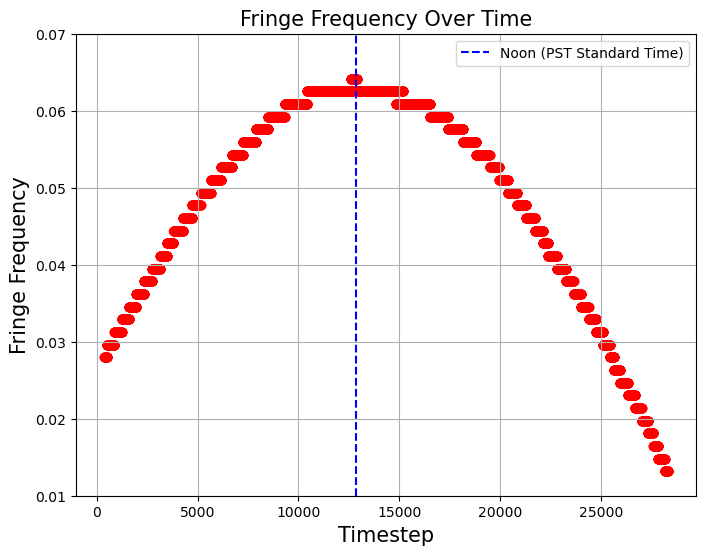

timestep 0: observed = 0.0279605, estimated = 0.0157474
timestep 5000: observed = 0.0493421, estimated = 0.0342857
timestep 10000: observed = 0.0608553, estimated = 0.0458591
timestep 15000: observed = 0.0608553, estimated = 0.0481158
timestep 20000: observed = 0.0509868, estimated = 0.0405973
timestep 25000: observed = 0.0296053, estimated = 0.0248304
27958
b_ew = 26.266 ± 0.003 m
b_ns = 2.234 ± 0.006 m
Reduced chi-squared = 182.653


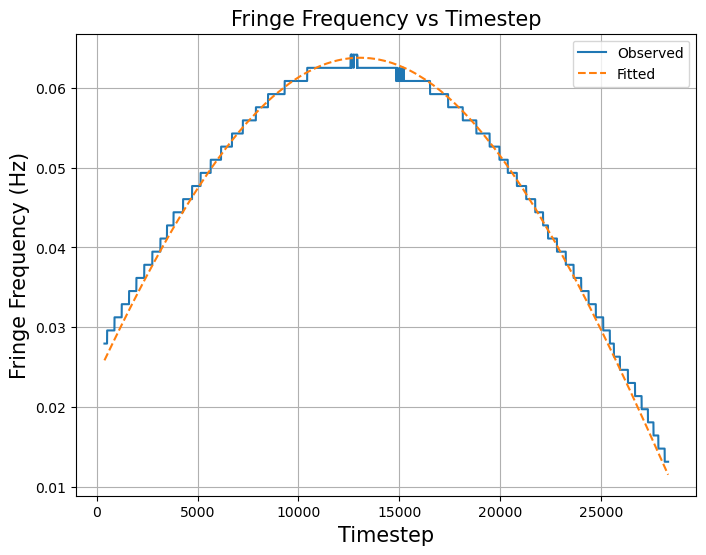

Window = 385


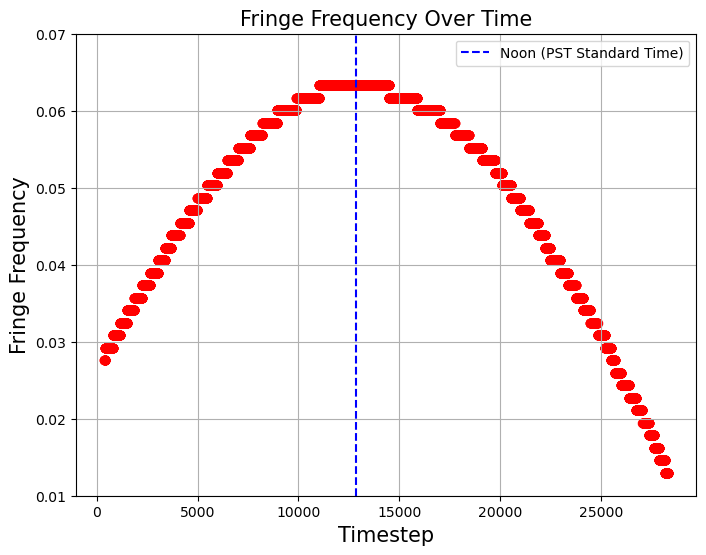

timestep 0: observed = 0.0275974, estimated = 0.0157474
timestep 5000: observed = 0.0487013, estimated = 0.0342857
timestep 10000: observed = 0.0616883, estimated = 0.0458591
timestep 15000: observed = 0.0616883, estimated = 0.0481158
timestep 20000: observed = 0.0503247, estimated = 0.0405973
timestep 25000: observed = 0.0292208, estimated = 0.0248304
27948
b_ew = 26.306 ± 0.003 m
b_ns = 2.246 ± 0.006 m
Reduced chi-squared = 152.755


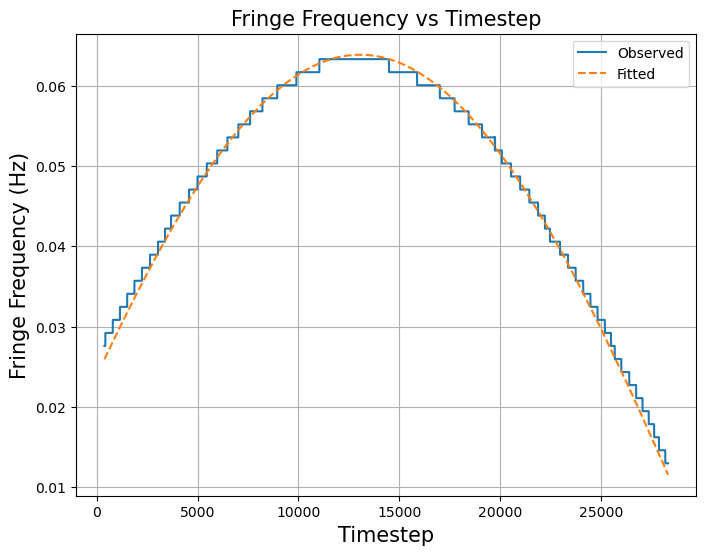

Window = 390


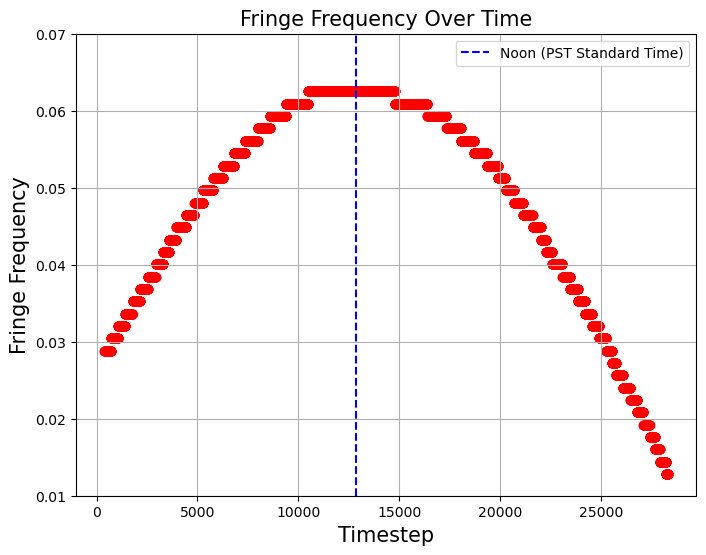

timestep 0: observed = 0.0288462, estimated = 0.0157474
timestep 5000: observed = 0.0496795, estimated = 0.0342857
timestep 10000: observed = 0.0608974, estimated = 0.0458591
timestep 15000: observed = 0.0608974, estimated = 0.0481158
timestep 20000: observed = 0.0496795, estimated = 0.0405973
timestep 25000: observed = 0.0288462, estimated = 0.0248304
27938
b_ew = 26.216 ± 0.003 m
b_ns = 2.241 ± 0.006 m
Reduced chi-squared = 175.123


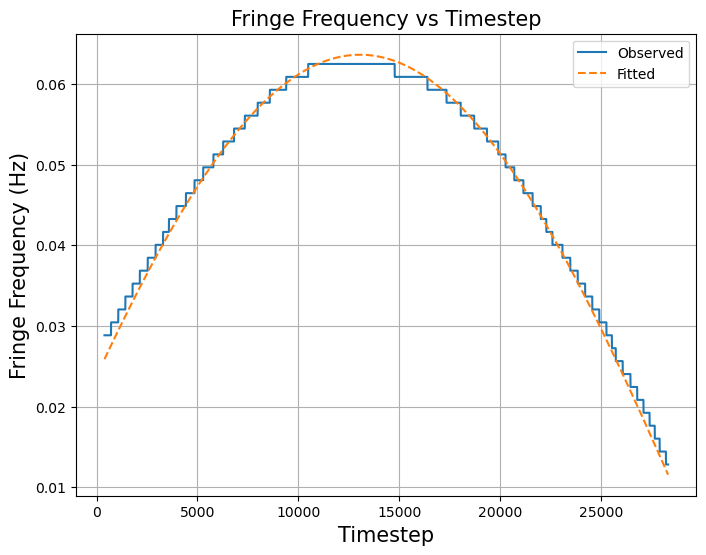

Window = 395


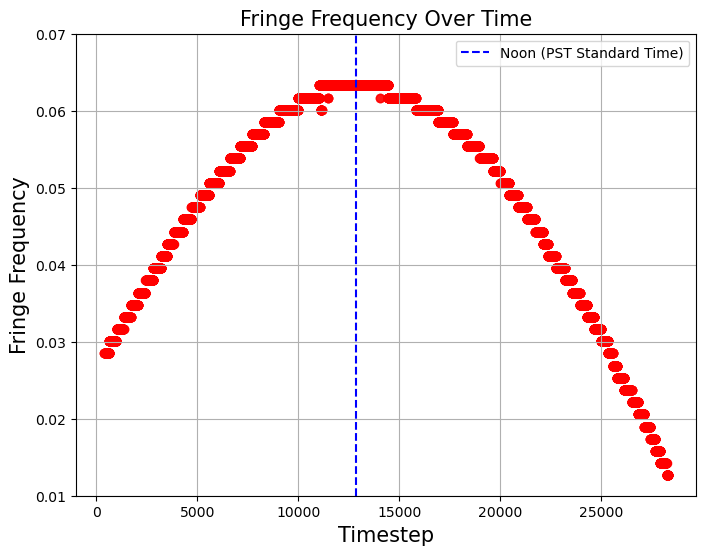

timestep 0: observed = 0.028481, estimated = 0.0157474
timestep 5000: observed = 0.0490506, estimated = 0.0342857
timestep 10000: observed = 0.0617089, estimated = 0.0458591
timestep 15000: observed = 0.0617089, estimated = 0.0481158
timestep 20000: observed = 0.0506329, estimated = 0.0405973
timestep 25000: observed = 0.028481, estimated = 0.0248304
27928
b_ew = 26.269 ± 0.003 m
b_ns = 2.247 ± 0.006 m
Reduced chi-squared = 144.190


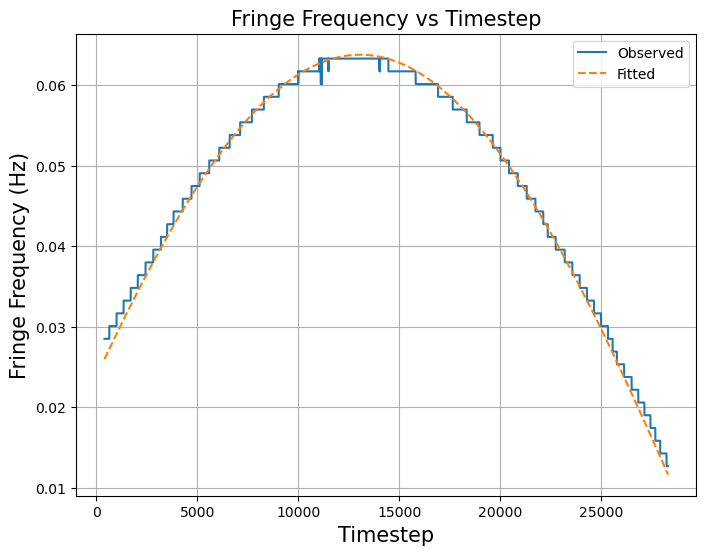

Window = 400


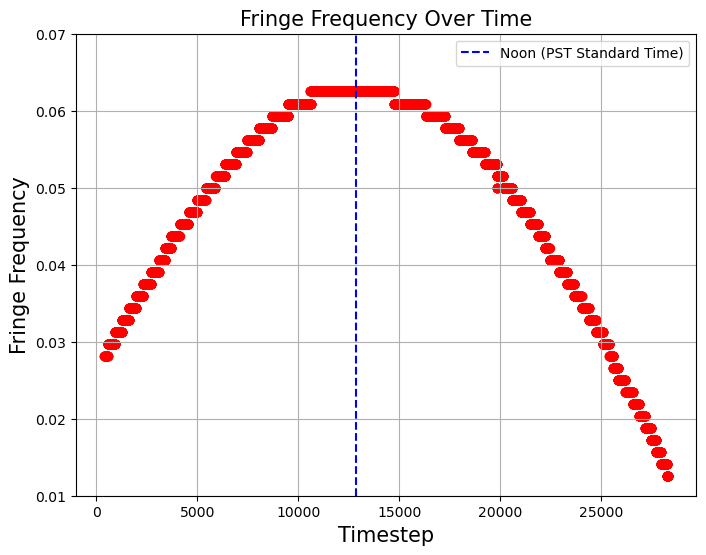

timestep 0: observed = 0.028125, estimated = 0.0157474
timestep 5000: observed = 0.0484375, estimated = 0.0342857
timestep 10000: observed = 0.0609375, estimated = 0.0458591
timestep 15000: observed = 0.0609375, estimated = 0.0481158
timestep 20000: observed = 0.05, estimated = 0.0405973
timestep 25000: observed = 0.0296875, estimated = 0.0248304
27918
b_ew = 26.182 ± 0.003 m
b_ns = 2.241 ± 0.006 m
Reduced chi-squared = 161.736


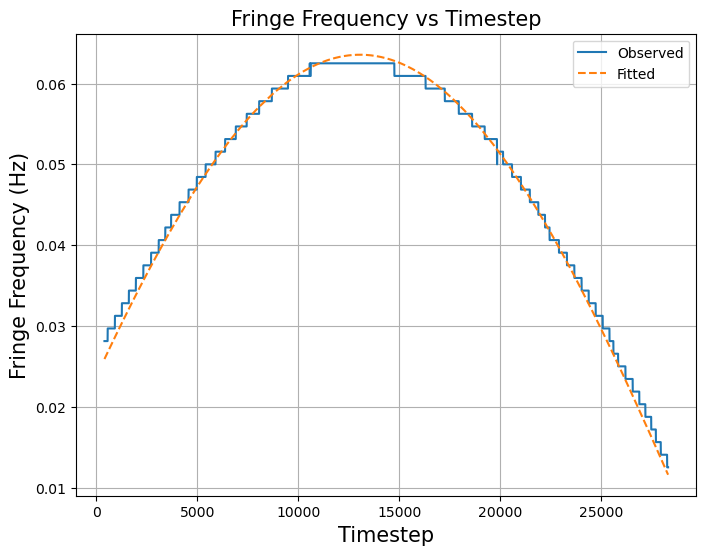

Window = 405


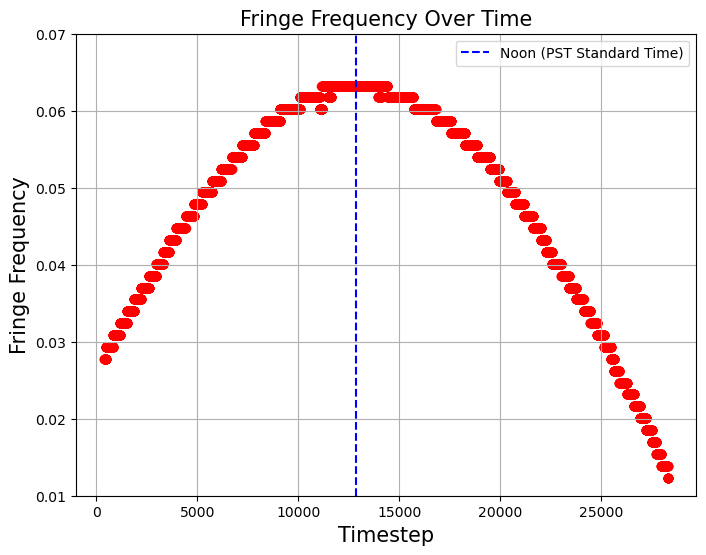

timestep 0: observed = 0.0277778, estimated = 0.0157474
timestep 5000: observed = 0.0493827, estimated = 0.0342857
timestep 10000: observed = 0.0617284, estimated = 0.0458591
timestep 15000: observed = 0.0617284, estimated = 0.0481158
timestep 20000: observed = 0.0493827, estimated = 0.0405973
timestep 25000: observed = 0.029321, estimated = 0.0248304
27908
b_ew = 26.216 ± 0.003 m
b_ns = 2.247 ± 0.006 m
Reduced chi-squared = 144.364


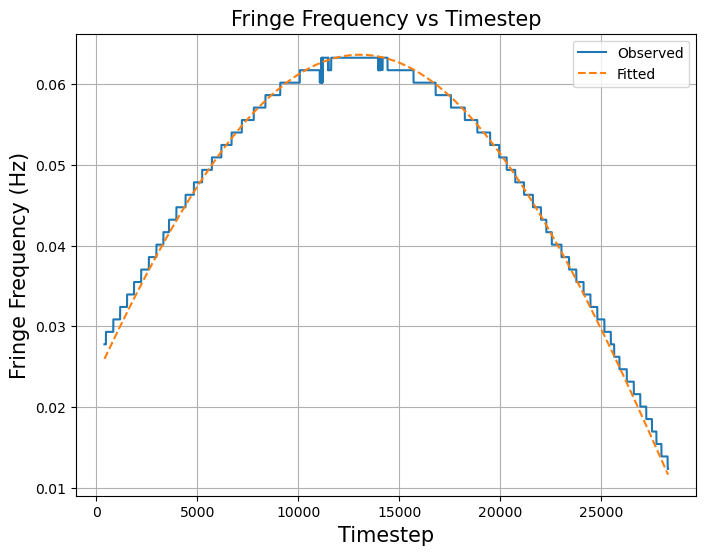

Window = 410


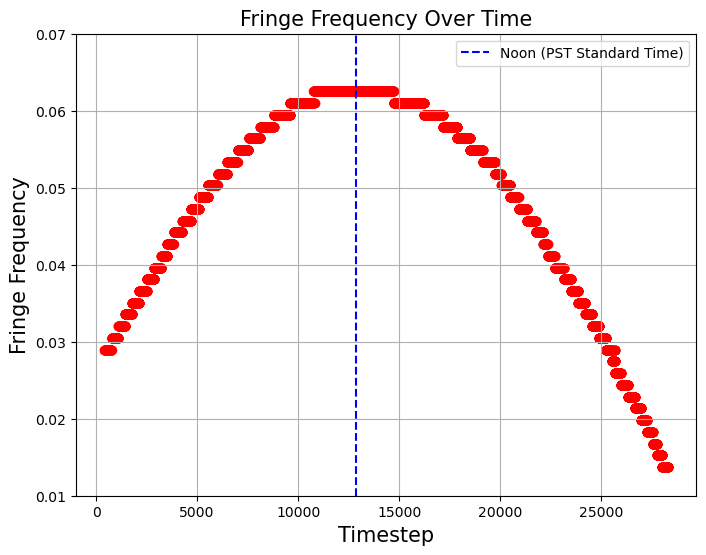

timestep 0: observed = 0.0289634, estimated = 0.0157474
timestep 5000: observed = 0.0487805, estimated = 0.0342857
timestep 10000: observed = 0.0609756, estimated = 0.0458591
timestep 15000: observed = 0.0609756, estimated = 0.0481158
timestep 20000: observed = 0.0503049, estimated = 0.0405973
timestep 25000: observed = 0.0289634, estimated = 0.0248304
27898
b_ew = 26.149 ± 0.003 m
b_ns = 2.242 ± 0.006 m
Reduced chi-squared = 154.082


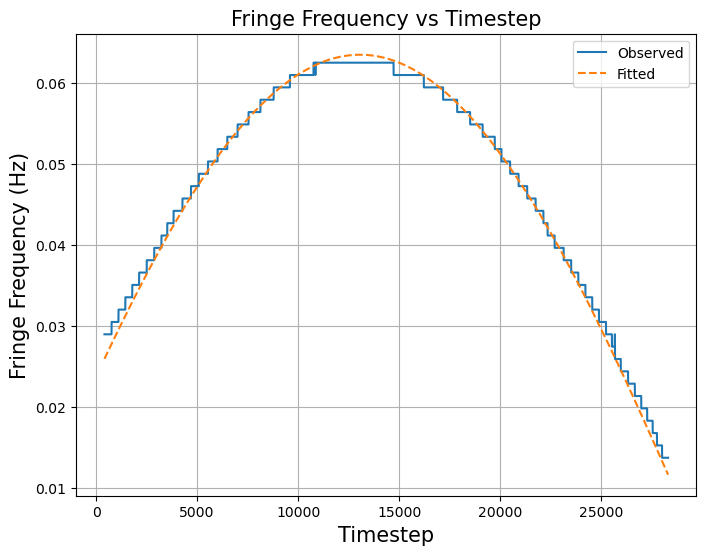

Window = 415


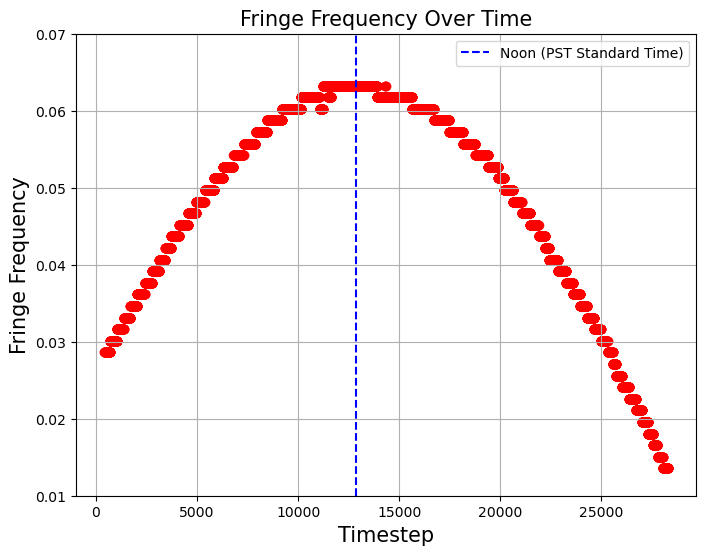

timestep 0: observed = 0.0286145, estimated = 0.0157474
timestep 5000: observed = 0.0496988, estimated = 0.0342857
timestep 10000: observed = 0.061747, estimated = 0.0458591
timestep 15000: observed = 0.061747, estimated = 0.0481158
timestep 20000: observed = 0.0496988, estimated = 0.0405973
timestep 25000: observed = 0.0286145, estimated = 0.0248304
27888
b_ew = 26.168 ± 0.003 m
b_ns = 2.250 ± 0.006 m
Reduced chi-squared = 142.547


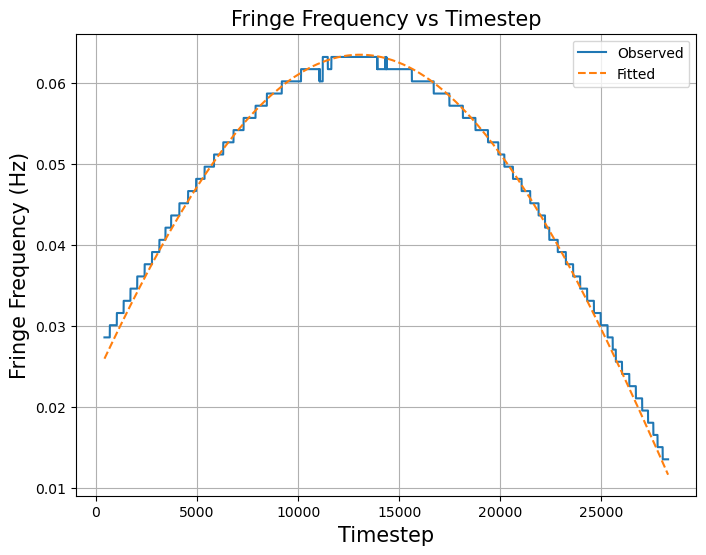

In [19]:
for i in range(len(HAs)):
    if HAs[i] < 0:
        HAs[i] += 2 * np.pi

for window in range(380, 416, 5):
    print(f"Window = {window}")
    observed_fringe_freqs = graphFringeFreqOverTime(horizon_complex, channel=600, window=window, resampling=True, vertical_line=noon_timestep, ylim=(0.01, 0.07))
    indices = np.linspace(window+1, len(horizon_complex)-(window+1), len(horizon_complex)-2*(window+1), dtype=int)

    X, y, indices_clean, HAs_clean, DECs_clean, observed_fringe_clean = constructDesignMatrix(
        indices, observed_fringe_freqs, HAs, DECs, L, w_earth, wavelen, good_mask=None, undersample=False, step=300
    )
    
    estimated_fringe_freqs = []
    Q_ew = (b_ew_guess / wavelen) * np.cos(DECs)
    Q_ns = (b_ns_guess / wavelen) * np.sin(L) * np.cos(DECs)
    estimated_fringe_freqs = (Q_ew * np.cos(HAs) - Q_ns * np.sin(HAs)) * w_earth

    steps = 5000
    for i in range(0, len(observed_fringe_freqs), steps):
        obs = round(observed_fringe_freqs[i], 7)
        est = round(estimated_fringe_freqs[i], 7)
        print(f"timestep {i}: observed = {obs}, estimated = {est}")

    b_ew_init_guess = b_ew_guess
    b_ns_init_guess = b_ns_guess
    beta, errors, chi2_red, result_obj = fit_baseline_least_squares(X, y, initial_guess=(b_ew_init_guess, b_ns_init_guess))
    b_ew, b_ns = beta

    print(f"b_ew = {b_ew:.3f} ± {errors[0]:.3f} m")
    print(f"b_ns = {b_ns:.3f} ± {errors[1]:.3f} m")
    print(f"Reduced chi-squared = {chi2_red:.3f}")

    plt.figure(figsize=graphSizeSingle)

    plt.plot(indices_clean, y * w_earth, label='Observed')
    Q_ew = (b_ew / wavelen) * np.cos(DECs_clean)
    Q_ns = (b_ns / wavelen) * np.sin(L) * np.cos(DECs_clean)
    estimated = (Q_ew * np.cos(HAs_clean) - Q_ns * np.sin(HAs_clean)) * w_earth
    plt.plot(indices_clean, estimated, label='Fitted', linestyle='--')
    plt.xlabel('Timestep', fontsize=axisSize)
    plt.ylabel('Fringe Frequency (Hz)', fontsize=axisSize)
    plt.title('Fringe Frequency vs Timestep', size=titleSize)
    plt.legend()
    plt.grid(True)
    plt.show()

# Reduced Chi Squared for different windows:
# Undersampling = US

# Frequency Channel 600
#           No US:      US (s=300):                        
# 385:      151.273     130.548                                    
# 395:      142.692                     
# 405:      143.544                                      
# 415:      141.220      
# 
# Frequency Channel 540
#           No US:      US (s=300):   
# 385:      000000      135.696       
# 410:      000000      130.518     
# 
# # Frequency Channel 700
#           No US:      US (s=300):   
# 405:      138.081          
# 415:      133.321      133.654   


# 600 MHz, Window = 385, Undersampling (step=300), Red chi = 130.548, 
# Fit = b_ew = 21.929 ± 0.038 m, b_ns = 1.884 ± 0.076 m

# 540 MHz, window = 410, Undersampling (step=300), Red chi = 130.518,
# Fit = b_ew = 21.802 ± 0.038 m, b_ns = 1.799 ± 0.077 m m

NOTES:  

dont do absolute value, keep real and complex data and find way to fix systematics (misalignment)?

waterfall plot for angle flip axes

non perfect bessel func bc not perfect disk (sun spot delta -> (FFT) -> flat function / baseline instead of 0)

In [22]:
def get_source_unit_vector(ra, dec, jd):
    # Both should be in radians
    alt, az = ugradio.coord.get_altaz(np.degrees(ra), np.degrees(dec), jd)
    alt_rad = np.radians(alt)
    az_rad = np.radians(az)

    l = np.cos(alt_rad) * np.sin(az_rad)
    m = np.sin(alt_rad)
    n = np.sqrt(1 - l**2 - m**2)
    return l, m, n

def get_baseline_unit_vector(b_ew, b_ns, has):
    # b_ew and b_ns should be in meters, has in radians
    u = (b_ew * np.cos(has)) / wavelen
    v = (b_ns * np.sin(has)) / wavelen
    w = (b_ew * np.sin(has) + b_ns * np.cos(has)) / wavelen
    return u, v, w

def joint_vis_model(b_ew, b_ns, ra, ha, dec, theta_rad, jd):
    # b_ew and b_ns should be in meters, ra and ha and dec in radians
    u, v, w = get_baseline_unit_vector(b_ew, b_ns, ha)
    l, m, n = get_source_unit_vector(ra, dec, jd)

    dot_product = u * l + v * m + w * n
    approximation = b_ew * np.cos(ha)
    fringe_phasor = np.exp(-1j * (2 * np.pi) * (dot_product))

    x = 2 * np.pi * theta_rad * np.sqrt(u**2 + v**2)
    bessel = np.ones_like(x)
    bessel[x != 0] = j1(x[x != 0]) / x[x!= 0]

    return fringe_phasor * bessel

def residuals(theta_rad, data, b_ew, b_ns, ras, has, decs, jd):

    model_vis = joint_vis_model(b_ew, b_ns, ras, has, decs, theta_rad, jd)
    return np.concatenate([
        (model_vis.real - data.real),
        (model_vis.imag - data.imag)
    ])

c = 3e8
w_earth = (2 * np.pi) / (24 * 60 * 60)
#b_ew = 21.802
#b_ns = 1.799
#b_ew = 20.4
#b_ns = 0.64
#wavelen = 0.025

channel = 600
channel_data = horizon_complex[:, channel]

for b_ew, b_ns in [(20.4, 0.64), (21.802, 1.799), (21.929, 1.884), (26.168, 2.250)]:
    for wavelen in [0.025, 0.0285516627, 0.0299792458]:
        init_theta = 0.00465
        result = least_squares(
            residuals,
            x0=[init_theta],
            args=(channel_data, b_ew, b_ns, RAs, HAs, DECs, time_data_jd)
        )

        residuals_vec = result.fun
        N, p = len(y), 2
        sigma2 = np.sum(residuals_vec**2) / (N - p)
        cov = sigma2 * np.linalg.inv(X.T @ X)
        errors = np.sqrt(np.diag(cov))
        chi2_red = sigma2

        print(f"b_ew = {b_ew:.3f}, b_ns = {b_ns:.3f}, wavelen = {wavelen:.10f}")
        best_theta = result.x[0]
        print(f"Best-fit theta (radians): {2 * best_theta}")
        print(f"In arcminutes: {np.degrees(2 * best_theta) * 60:.2f}")
        print(f"Reduced chi-squared: {chi2_red:.3f}")

# Best fit so far: 
#Reduced chi-squared: 1.825
#b_ew = 20.400, b_ns = 0.640, wavelen = 0.0285516627
#Best-fit theta (radians): 0.009504276575382045
#In arcminutes: 32.67

# Same wavelen val, but different b_ew and b_ns:

b_ew = 20.400, b_ns = 0.640, wavelen = 0.0250000000
Best-fit theta (radians): 0.011666001720122204
In arcminutes: 40.10
Reduced chi-squared: 1.825
b_ew = 20.400, b_ns = 0.640, wavelen = 0.0285516627
Best-fit theta (radians): 0.009504276575382045
In arcminutes: 32.67
Reduced chi-squared: 1.824
b_ew = 20.400, b_ns = 0.640, wavelen = 0.0299792458
Best-fit theta (radians): 0.005851372835654834
In arcminutes: 20.12
Reduced chi-squared: 1.822
b_ew = 21.802, b_ns = 1.799, wavelen = 0.0250000000
Best-fit theta (radians): 0.008180364957759156
In arcminutes: 28.12
Reduced chi-squared: 1.825
b_ew = 21.802, b_ns = 1.799, wavelen = 0.0285516627
Best-fit theta (radians): 0.007983811459090674
In arcminutes: 27.45
Reduced chi-squared: 1.825
b_ew = 21.802, b_ns = 1.799, wavelen = 0.0299792458
Best-fit theta (radians): 0.010386979078299307
In arcminutes: 35.71
Reduced chi-squared: 1.825
b_ew = 21.929, b_ns = 1.884, wavelen = 0.0250000000
Best-fit theta (radians): 0.01080428210513249
In arcminutes: 37.14